## Laplacian Eigenmaps

In [1]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

%matplotlib inline

## Dataset

### Dataset


The dataset is the citation network Cora.

It can be downloaded by clicking [here](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz)

The following is the description of the dataset from the publisher,

> The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words. The README file in the dataset provides more details. 

For this demo, we ignore the word vectors associated with each paper. We are only interested in the network structure and the **subject** attribute of each paper.

Download and unzip the cora.tgz file to a location on your computer. 

We assume that the dataset is stored in the directory

`~/data/cora/`

where the files `cora.cites` and `cora.content` can be located.

We are going to load the data into a networkx object.

### Specify the data input directory

**Note:** Make sure this is set correctly on your machine!

In [2]:
data_dir = os.path.expanduser("~/data/cora/")

In [3]:
cora_location = os.path.expanduser(os.path.join(data_dir, "cora.cites"))
g_nx = nx.read_edgelist(path=cora_location)

# load the node attribute data
cora_data_location = os.path.expanduser(os.path.join(data_dir, "cora.content"))
node_attr = pd.read_csv(cora_data_location, sep='\t', header=None)
values = { str(row.tolist()[0]): row.tolist()[-1] for _, row in node_attr.iterrows()}
nx.set_node_attributes(g_nx, values, 'subject')

We are going to use only the largest graph connected component.

In [4]:
# Select the largest connected component. For clarity we ignore isolated
# nodes and subgraphs; having these in the data does not prevent the
# algorithm from running and producing valid results.
g_nx_ccs = (g_nx.subgraph(c).copy() for c in nx.connected_components(g_nx))
g_nx = max(g_nx_ccs, key=len)
print("Largest subgraph statistics: {} nodes, {} edges".format(
    g_nx.number_of_nodes(), g_nx.number_of_edges()))

Largest subgraph statistics: 2485 nodes, 5069 edges


Retrieve the labels for the nodes in the graph

In [5]:
node_ids = list(g_nx.nodes())
node_ids[:10]

['35',
 '1033',
 '103482',
 '103515',
 '1050679',
 '1103960',
 '1103985',
 '1109199',
 '1112911',
 '1113438']

In [6]:
node_targets = [ g_nx.node[node_id]['subject'] for node_id in node_ids]

In [7]:
node_targets[:10]

['Genetic_Algorithms',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Genetic_Algorithms',
 'Genetic_Algorithms',
 'Genetic_Algorithms',
 'Genetic_Algorithms',
 'Genetic_Algorithms',
 'Genetic_Algorithms',
 'Genetic_Algorithms']

In [8]:
np.unique(node_targets) # should be 1 of 7 subjects

array(['Case_Based', 'Genetic_Algorithms', 'Neural_Networks',
       'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning',
       'Theory'], dtype='<U22')

In [9]:
len(node_targets)

2485

In [10]:
len(g_nx.nodes())

2485

In [11]:
y = node_targets
y[0:5]

['Genetic_Algorithms',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Genetic_Algorithms',
 'Genetic_Algorithms']

In [12]:
# We are going to use these to draw the data such that nodes with the same subject have the
# same color.
colors = {'Case_Based': 'black',
          'Genetic_Algorithms': 'red',
          'Neural_Networks': 'blue',
          'Probabilistic_Methods': 'green',
          'Reinforcement_Learning': 'aqua',
          'Rule_Learning': 'purple',
          'Theory': 'yellow'}

### Calculate the graph Laplacian

### First retrieve the adjacency matrix from the networkx object

In [13]:
A = nx.to_numpy_array(g_nx)  # The graph adjacency matrix

### Calculate the degree matrix

In [14]:
D = np.diag(A.sum(axis=1))  # sum rows

print(D)

[[168.   0.   0. ...   0.   0.   0.]
 [  0.   5.   0. ...   0.   0.   0.]
 [  0.   0.   6. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   4.   0.   0.]
 [  0.   0.   0. ...   0.   4.   0.]
 [  0.   0.   0. ...   0.   0.   2.]]


### Calculate the Laplacian

In [15]:
L = D-A  # The Graph Laplacian

In [16]:
L

array([[168.,  -1.,  -1., ...,   0.,   0.,   0.],
       [ -1.,   5.,   0., ...,   0.,   0.,   0.],
       [ -1.,   0.,   6., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   4.,  -1.,  -1.],
       [  0.,   0.,   0., ...,  -1.,   4.,   0.],
       [  0.,   0.,   0., ...,  -1.,   0.,   2.]])

### Calculate the eigenvectors and corresponding eigenvalues

In [17]:
embedding_size = 32

In [18]:
w, v = np.linalg.eigh(L)  # w is vector of eigenvalues
                          # v columns are eigenvectors

order = np.argsort(w)  # from smallest to largest eigenvalue
w = w[order]
v_0 = v[:, order[0]]
v = v[:, order[1:(embedding_size+1)]]  # ignore the first one

In [19]:
print(w)

[-4.75186351e-15  1.48014820e-02  2.36128446e-02 ...  7.50272239e+01
  7.90471764e+01  1.69014150e+02]


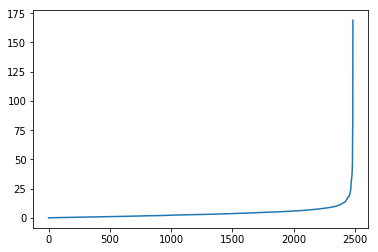

In [20]:
plt.plot(w)

In [21]:
v_0

array([0.02006027, 0.02006027, 0.02006027, ..., 0.02006027, 0.02006027,
       0.02006027])

In [22]:
print(v)

[[-0.00211898  0.00599277 -0.00367151 ... -0.00094008  0.00019546
   0.00015991]
 [-0.002144    0.00611701 -0.00381872 ...  0.00051456 -0.00056262
   0.00069991]
 [-0.00183635  0.00473534 -0.00298016 ...  0.00390489 -0.0020503
   0.00024456]
 ...
 [-0.00133535  0.00346527 -0.00254527 ... -0.0030409   0.00621298
  -0.00129151]
 [-0.00138206  0.00344062 -0.00257468 ... -0.00381997  0.00629437
  -0.00179128]
 [-0.00117545  0.00345737 -0.0023799  ... -0.00019461  0.00491115
   0.00043305]]


In [23]:
tsne = TSNE(n_components=2)  # use PCA for speed
v_pr = tsne.fit_transform(v)

In [24]:
v_pr.shape

(2485, 2)

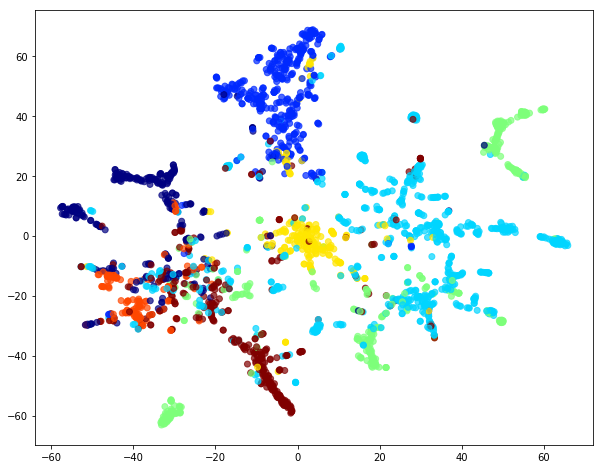

In [25]:
# draw the points
alpha=0.7
label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets]

fig = plt.figure(figsize=(10,8))
plt.scatter(v_pr[:,0], 
            v_pr[:,1], 
            c=node_colours, cmap="jet", alpha=alpha)
# fig.savefig("LE32_embeddings.png")

### Train a Random Forest classifier

In [26]:
X = v
Y = np.array(y)

In [27]:
X.shape, Y.shape

((2485, 32), (2485,))

In [28]:
clf = RandomForestClassifier(n_estimators=10, min_samples_leaf=4)

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=140)

/Users/eli024/Projects/stellar-practical-ml-on-graphs/practical-ml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [29]:
X_train.shape, X_test.shape

((140, 32), (2345, 32))

In [30]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [31]:
print("score on X_train {}".format(clf.score(X_train, y_train)))
print("score on X_test {}".format(clf.score(X_test, y_test)))

score on X_train 0.8785714285714286
score on X_test 0.7475479744136461
